# Smiley Data with SQL

In this hands-on exercise we will be looking at data from the Danish Veterinary and Food Administration's "smiley"-data. This dataset contains a record for every company in Denmark that handles food.

The dataset is availible from here: https://www.findsmiley.dk/Statistik/Smiley_data/Sider/default.aspx

In [1]:
data = spark.read.csv("gs://big-data-course-datasets/smiley/smiley.csv",  \
             header=True).cache()

One of the great features of Spark is the possibility of specifying queries in SQL-syntax. This is great for data analysts who have more experience with SQL than lower level programming. The original interface to Spark was the RDD (resilient distributed datasets), which can be thought of as a list og objects. 

The SQL-capabilities of Spark are based on the newer DataFrame interface, which can be thought of as tables rather than lists. 

The data is loaded as usual above, but without the **.rdd**, which means that we will have a DataFrame rather than an RDD.

The only thing we need to do to be able to access the data is tell SparkSQL to make the DataFrame available as a table with the **registerTempTable()** function:

In [2]:
data.registerTempTable("smiley")

SparkSQL follows the Hive SQL syntax. Documentation of this can be found here: https://cwiki.apache.org/confluence/display/Hive/LanguageManual+Select

We are now ready to write SQL queries against the **smiley**-table. The **toPandas()** function collects the data to the client machine in a Python Pandas dataframe, which is displayed nicely in Jupyter.

In [3]:
spark.sql("SELECT * FROM smiley LIMIT 5").toPandas()

,navnelbnr,cvrnr,pnr,brancheKode,branche,virksomhedstype,navn1,adresse1,postnr,By,...,tredjeseneste_kontrol,tredjeseneste_kontrol_dato,fjerdeseneste_kontrol,fjerdeseneste_kontrol_dato,URL,reklame_beskyttelse,Elite_Smiley,Geo_Lng,Geo_Lat,_c23
0,20241,31771676,1014780722,47.29.00.A,"Apoteker, materialister, helsekostforretninger...",Detail,Nordic Health Group v/Lasse Arensbach,"John F. Kennedys Plads 1 E, 4",9000,Aalborg,...,3,2010-06-23 00:00:00.0000000,1,2009-08-07 00:00:00.0000000,http://www.findsmiley.dk/da-DK/Searching/Detai...,0,0,9.919034,57.042357,None
1,558011,20458984,1020058516,DD.10.71.20,Specialforretning - Bager m.v.,Detail,City Bakery ApS,Nørregade 13,3390,Hundested,...,1,2016-02-01 00:00:00.0000000,1,2015-02-26 00:00:00.0000000,http://www.findsmiley.dk/da-DK/Searching/Detai...,0,1,11.850424,55.964534,None
2,659007,35954716,1021247800,DD.10.71.20,Specialforretning - Bager m.v.,Detail,føtex Bager,Sølvgade 10,1307,København K,...,None,None,None,None,http://www.findsmiley.dk/da-DK/Searching/Detai...,1,0,12.583998,55.686013,None
3,43790,13471282,1000570100,DD.10.71.20,Specialforretning - Bager m.v.,Detail,VENNELYSTVEJENS BAGERI V/KENT MØLLER JOHANSEN,Vennelystvej 56 A,8960,None,...,1,2016-02-18 00:00:00.0000000,1,2015-06-03 00:00:00.0000000,http://www.findsmiley.dk/da-DK/Searching/Detai...,0,1,10.058702,56.444878,None
4,513605,34583730,1017699098,DD.10.71.20,Specialforretning - Bager m.v.,Detail,Firdaws ApS,Enghavevej 172,2450,København SV,...,2,2017-06-01 00:00:00.0000000,1,2016-07-13 00:00:00.0000000,http://www.findsmiley.dk/da-DK/Searching/Detai...,0,0,12.537889,55.656613,None


We can now explore the data. For example, we can count how many of the companies that handle food have an elite-smiley which is the best achievable smiley possible.

In [4]:
spark.sql("SELECT Elite_Smiley, count(*) AS c FROM smiley GROUP BY Elite_Smiley").toPandas()

,Elite_Smiley,c
0,0,26444
1,1,27612


It turns out that about half of the companies have elite smileys. We can show this on a bar chart.

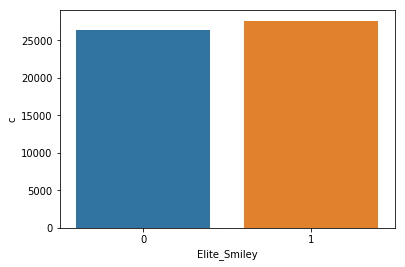

In [5]:
import seaborn as sns
import pandas as pd
%matplotlib inline

data=spark.sql("SELECT Elite_Smiley, count(*) AS c FROM smiley GROUP BY Elite_Smiley").toPandas()
sns.barplot(x="Elite_Smiley", y="c", data=data)


------------------

# Assignment

Try to use SparkSQL to answer some of these questions:

- Which type of shop has a higher fraction of elite smileys butchers (slagter) or shops selling fish (fisk)?
- Does companies with the word "pub" in its name have a higher fraction of elite smileys than shops with "delikatesse" in its name?
- Does comapnies with the word "sushi" in its name have a higher fraction of elite smileys than shops with "pizza" in its name?

There are several ways of aproaching this questions. To some it is easiest to have simple SQL-queries to retrieve data and then do the last bit of manipulation in Python afterwards. It is however entirely possible to write SQL queries to arrange the data as we would like.

In [6]:
data=spark.sql("""SELECT branche, AVG(elite_Smiley) elite_fraction
    FROM smiley 
    WHERE branche LIKE "%Slagter m.v.%" OR branche LIKE "%Fisk m.v.%"
    GROUP BY branche """).toPandas()
data

,branche,elite_fraction
0,Specialforretning - Slagter m.v.,0.725641
1,Specialforretning - Fisk m.v.,0.645977


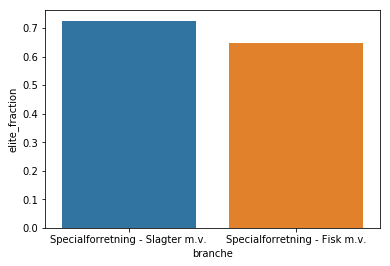

In [7]:
sns.barplot(x="branche", y="elite_fraction", data=data)

To group data by parts of the name is more challenging in SQL, but it can be done with a **CASE** clause.

In [8]:
data=spark.sql("""SELECT AVG(Elite_Smiley) elite_fraction,
(CASE WHEN (navn1 LIKE "%Pub%") THEN "Pub" ELSE "Delikatesse" END) AS type
FROM smiley
WHERE navn1 LIKE "%Pub%" OR navn1 LIKE "%Delikatesse%"
GROUP BY type
""").toPandas()
data

,elite_fraction,type
0,0.140496,Pub
1,0.751553,Delikatesse


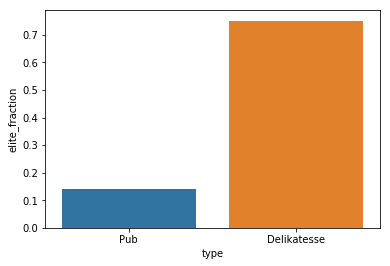

In [9]:
sns.barplot(x="type", y="elite_fraction", data=data)

In [10]:
data=spark.sql("""SELECT AVG(Elite_Smiley) elite_fraction,
(CASE WHEN (navn1 LIKE "%Sushi%") THEN "Sushi" ELSE "Pizza" END) AS type
FROM smiley
WHERE navn1 LIKE "%Sushi%" OR navn1 LIKE "%Pizza%"
GROUP BY type
""").toPandas()
data

,elite_fraction,type
0,0.494297,Sushi
1,0.554694,Pizza


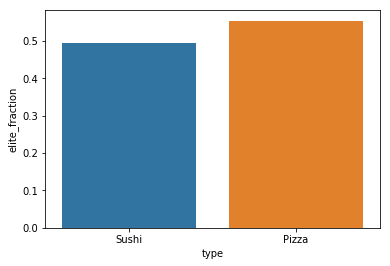

In [11]:
sns.barplot(x="type", y="elite_fraction", data=data)